# Final Project (ENPM 808W) 

### Are they going to cross? Pedestrian intent estimation for autonomous driving

This aim of this project is to design a software pipeline using data science and machine learning principles to estimate the intent of pedestrians, specifically whether they are going to cross in front of the autonomous driving vehicle. We accomplish this by analyzing the behavior cues humans display before crossing the road. 


### Imports Packages

In [1]:
# import the necessary packages
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import ast


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pedestrian Crossing Prediction

In this problem we use the opensource [JAAD dataset](http://data.nvision2.eecs.yorku.ca/JAAD_dataset/).

The dataset consists of tracked people in some videos from a car's dashcam.  Each of these people have been carefully annotated with a bunch of different attributes, such as whether or not they are stopped or moving fast or moving slow.  For this problem we will try to predict whether or not the pedestrian will cross the street in the next frame based on all previous data we have about the pedestrian.  We will use the bounding boxes of the pedestrians along with the other actions that they take to try to predict this for a test set.

## Dataframe

Each row of the dataframe consists of some meta data about the video id and the ped id, and then an ordered list of frames where that pedestrian appears.  

* frame_numbers - All the frames in which the pedestrian appears, this is expected to be a continous list of frames.
* bounding_boxes - This is the bounding box annotation of the pedestrian in each frame.  Each box is constructed of [box x, box y, box width, box height], where x and y represent the upper left hand corner of the box
* moving_slow, stopped, handwave, look, clear path, moving fast, looking, standing, slow down, nod, speed up - The annotated attributes used to train the model, each is a list that aligns with the frame_numbers field of whether or not the attribute is true for that frame number
* crossing - This is the field to be predicted, whether or not the pedestrian is crossing for this corresponding frame number 
* cross_overall - Whether or the person crossed at any point in the sequence

In [2]:
pedestrians_df = pd.read_csv('pedestrian_df.csv')
for col_name in ['bounding_boxes', 'frame_numbers', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'crossing', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']:
    pedestrians_df[col_name] = pedestrians_df[col_name].apply(ast.literal_eval)
pedestrians_df.head()

video_id ped_ind                                      frame_numbers  \
0  video_0071       1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  video_0071       2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  video_0204       1  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
3  video_0204       3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  video_0204       2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                      bounding_boxes  \
0  [[1209, 598, 51, 191], [1214, 598, 52, 192], [...   
1  [[1249, 621, 51, 127], [1254, 620, 51, 129], [...   
2  [[1135, 673, 28, 97], [1139, 672, 29, 92], [11...   
3  [[906, 670, 35, 65], [906, 672, 32, 65], [907,...   
4  [[1152, 657, 42, 114], [1158, 657, 42, 117], [...   

                                         moving slow  \
0  [False, False, False, False, False, False, Fal...   
1  [True, True, True, True, True, True, True, Tru...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                             stopped  \
0  [True, True, True, True, True, True, True, Tru...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [True, True, True, True, True, True, True, Tru...   

                                            handwave  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                                look  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                          clear path  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                            crossing  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [True, True, True, True, True, True, True, Tru...   
3  [True, True, True, True, True, True, True, Tru...   
4  [False, False, False, False, False, False, Fal...   

                                         moving fast  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                             looking  \
0  [False, False, False, False, False, False, Fal...   
1  [True, True, True, True, True, True, True, Tru...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [True, True, True, True, True, True, True, Tru...   

                                            standing  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False, False, False, False, False, False, Fal...   
3  [False, False, False, False, False, False, Fal...   
4  [False, False, False, False, False, False, Fal...   

                                           slow down  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, False, Fal...   
2  [False,

In [3]:
count = 0
for i, row in pedestrians_df.iterrows():
    count += len(row['frame_numbers'])

print("Number of Pedestrian-Frames: %d" % count)

Number of Pedestrian-Frames: 128220


In [4]:
# Let's take a more in-depth look at that first row:
print(pedestrians_df.iloc[0])
print(pedestrians_df.iloc[0]['frame_numbers'])

video_id                                                 video_0071
ped_ind                                                           1
frame_numbers     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
bounding_boxes    [[1209, 598, 51, 191], [1214, 598, 52, 192], [...
moving slow       [False, False, False, False, False, False, Fal...
stopped           [True, True, True, True, True, True, True, Tru...
handwave          [False, False, False, False, False, False, Fal...
look              [False, False, False, False, False, False, Fal...
clear path        [False, False, False, False, False, False, Fal...
crossing          [False, False, False, False, False, False, Fal...
moving fast       [False, False, False, False, False, False, Fal...
looking           [False, False, False, False, False, False, Fal...
standing          [False, False, False, False, False, False, Fal...
slow down         [False, False, False, False, False, False, Fal...
nod               [False, False, False, False, F

# Tasks

This project will involve:
- explore the dataset
- redefine the problem and select an appropriate metric
- unravel the existing per-pedestrian dataframe to build your new per-pedestrian-frame dataframe.  
- extract features
- split the data into train and validation sets (70%-30% split is probably about the right size)
- build a baseline that simply predicts the previous frames' "crossing" value for the next frame
- train machine learning models
- test final model on your validation set and produce confusion matrix

## 1. Dataset exploration
First step is to go through dataset in depth and make any possible observations about it. Following steps will help improve the understanding the data.
1. Define the size of dataset in two modalities
    - The number of pedestrians data is provided for
    - The number of frames the dataset is provided for
2. Deduce the types of features in the dataset
3. Plot the data points to make deductions about the high level patterns between input features and the output
4. Make observations about the trends and what kind of machine learning approaches might work

In [5]:
# parse the csv data file using pandas library
data = pd.read_csv('pedestrian_df.csv')
print("[INFO] Number of pedestrians in the dataset : ", len(data))

# parse the string data in each column to integer and boolean values
for col_name in ['bounding_boxes', 'frame_numbers', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'crossing', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']:
    data[col_name] = data[col_name].apply(ast.literal_eval)

# count the total frames for data accross all pedestrians in all videos
count = 0
for row in data['frame_numbers']:
    count += len(row)
print("[INFO] Number of frames in the dataset : ",count)

# calculate the number of features
columns = []
for col in data.columns:
    if col != 'video_id' and col !='ped_ind' and col != 'frame_numbers' and col!='cross_overall' and col!='crossing':
        columns.append(col)
print("[INFO] Features : ", columns)
print("[INFO] Number of features : ", len(columns))

# separate out list of input features
feature_set_full = ['moving slow', 'stopped', 'handwave', 'look', 'clear path',
            'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up', 'bounding_boxes']

[INFO] Number of pedestrians in the dataset :  666
[INFO] Number of frames in the dataset :  128220
[INFO] Features :  ['bounding_boxes', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']
[INFO] Number of features :  12


[INFO] For Video : video_0305 ; Pedestrian 1


/var/folders/jc/lg0z4n4j3g78ypg2cb93z5qc0000gn/T/ipykernel_7757/111514574.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


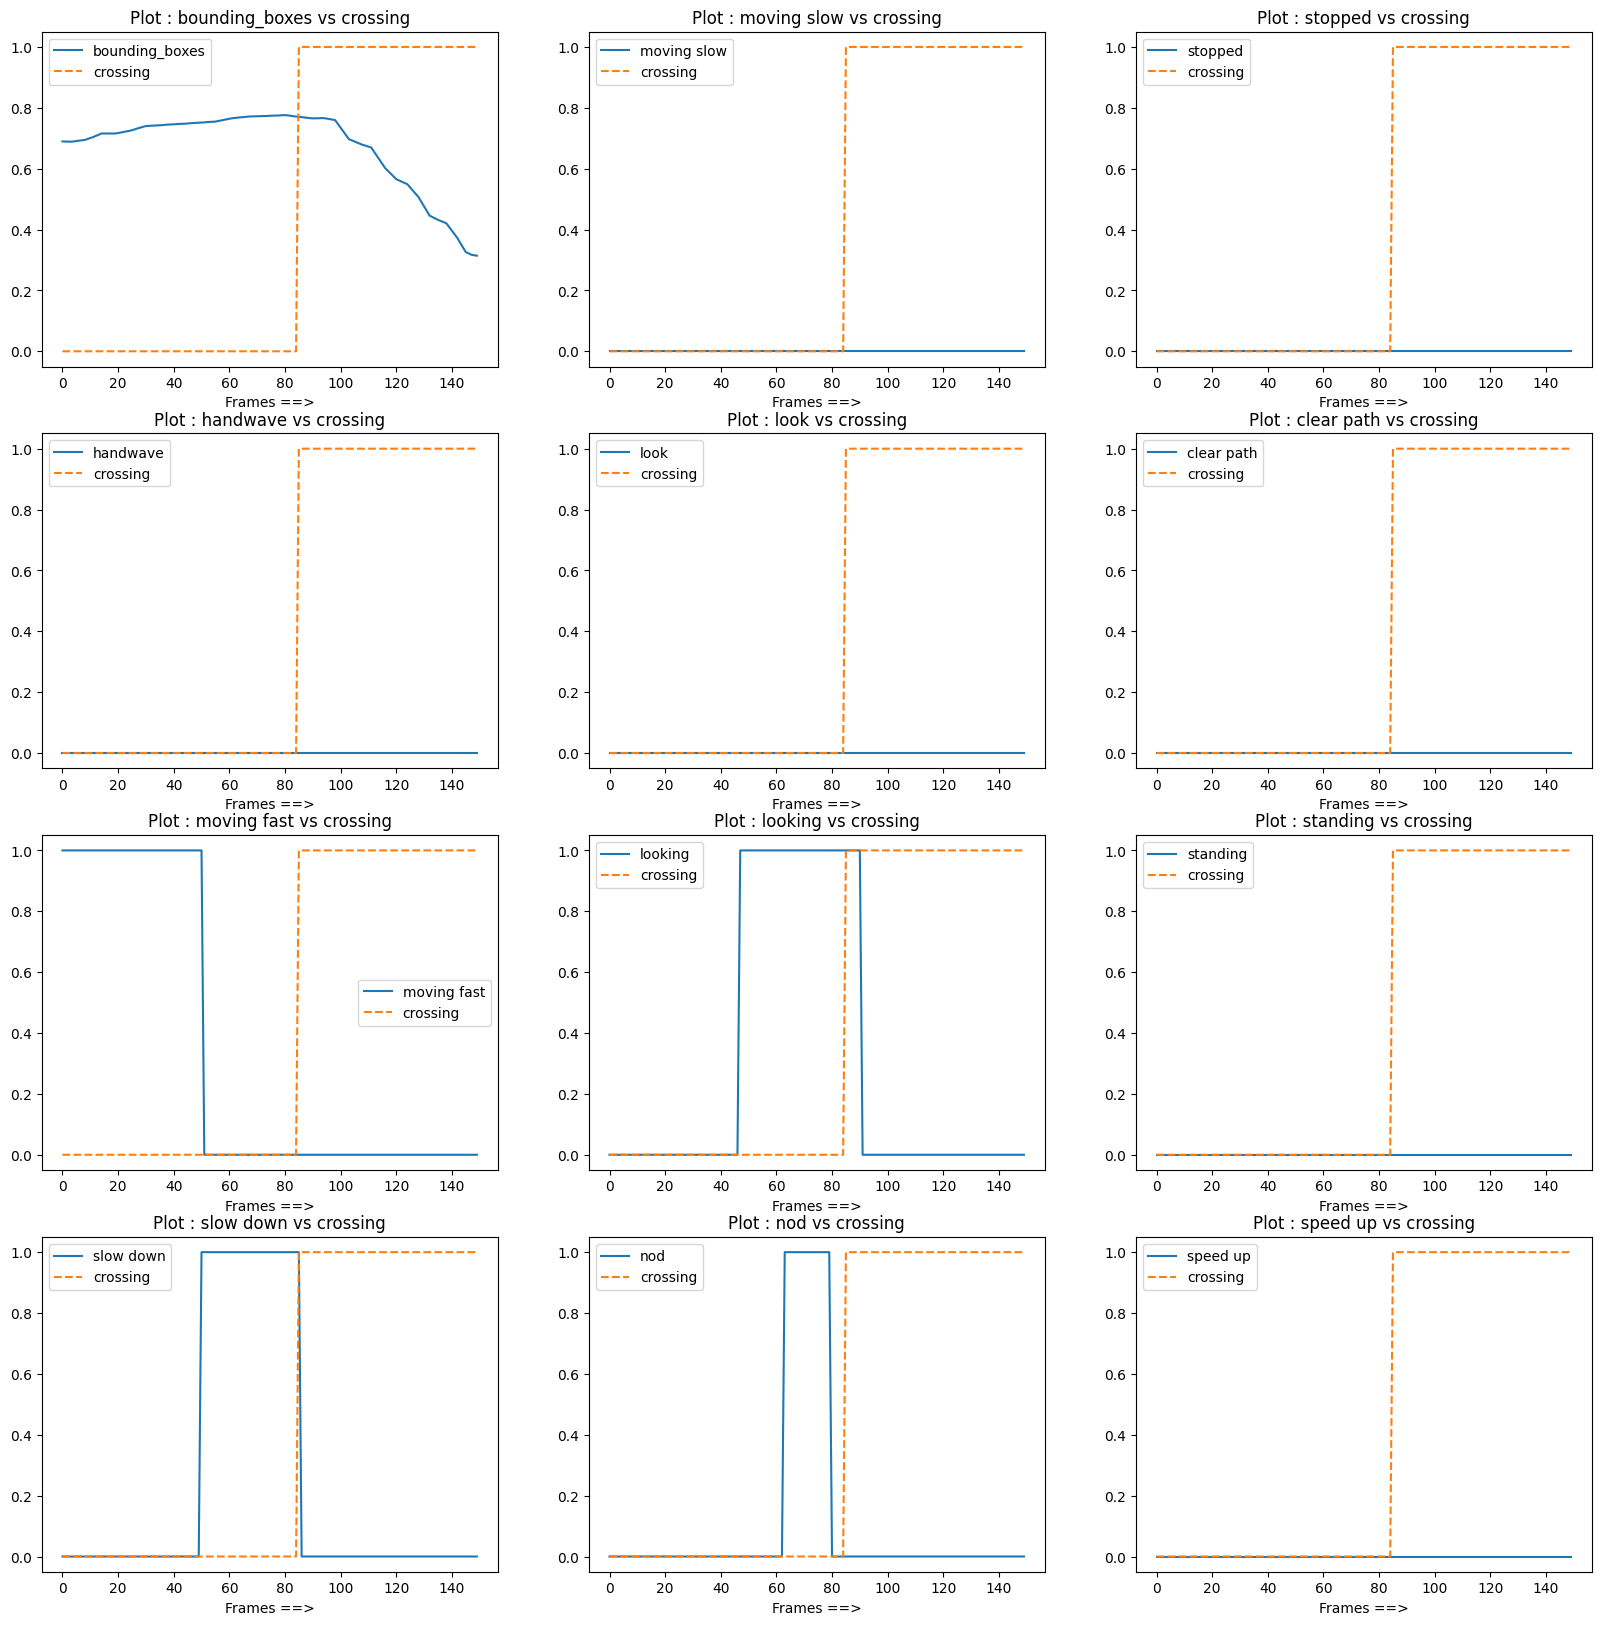

In [10]:
# generate a random data id to plot
idx = random.randint(0, len(data))
print("[INFO] For Video : {} ; Pedestrian {}".format(data.iloc[idx]['video_id'], 
                                                     data.iloc[idx]['ped_ind']))

# plot the data for all frames for each feature and 
# compare it to the crossing trend
fig, axs = plt.subplots(4, 3, figsize=(20,20))
img_w, img_h = 1920, 1080
for col, ax in zip(columns, axs.ravel()):
    # handle bounding boxes data seperately
    if col == 'bounding_boxes':
        bboxes_xcoords = []
        for bbox in data.iloc[idx][col]:
            # normalize the bounding box x-coordinate for each frame
            bboxes_xcoords.append(bbox[0]/img_w)
        ax.plot(data.iloc[idx]['frame_numbers'], bboxes_xcoords)
    else:
        ax.plot(data.iloc[idx]['frame_numbers'], data.iloc[idx][col])
    ax.plot( data.iloc[idx]['frame_numbers'], data.iloc[idx]['crossing'], linestyle='dashed')
    ax.set_title('Plot : {} vs crossing'.format(col))
    ax.set_xlabel("Frames ==>")
    ax.legend([col, 'crossing'])
fig.show()

### Observations
When the above plotting code is executed for different data points for videos, there are observations of clear correlations of some features like bounding boxes (x-coordinate), stopped, looking, look with pedestrian crossing intent. Following observations are worth noting:
1. Heavy gradients in bounding_boxes x coodinate during the crossing
2. 'stopped' feature is inversely correlated to crossing attempt
3. 'looking' feature is often high just before pedestrian attempts a crossing
4. Feature values from previous frames heavily influence the crossing intent of a pedestrian in current frame

The 3 features ('stopped', 'looking', 'bounding_boxes') are directly responsible for model's ability to predict the intent of pedestrian to attempt the crossing. Following specific result for 'video_0103' is a good representation of above observation: 

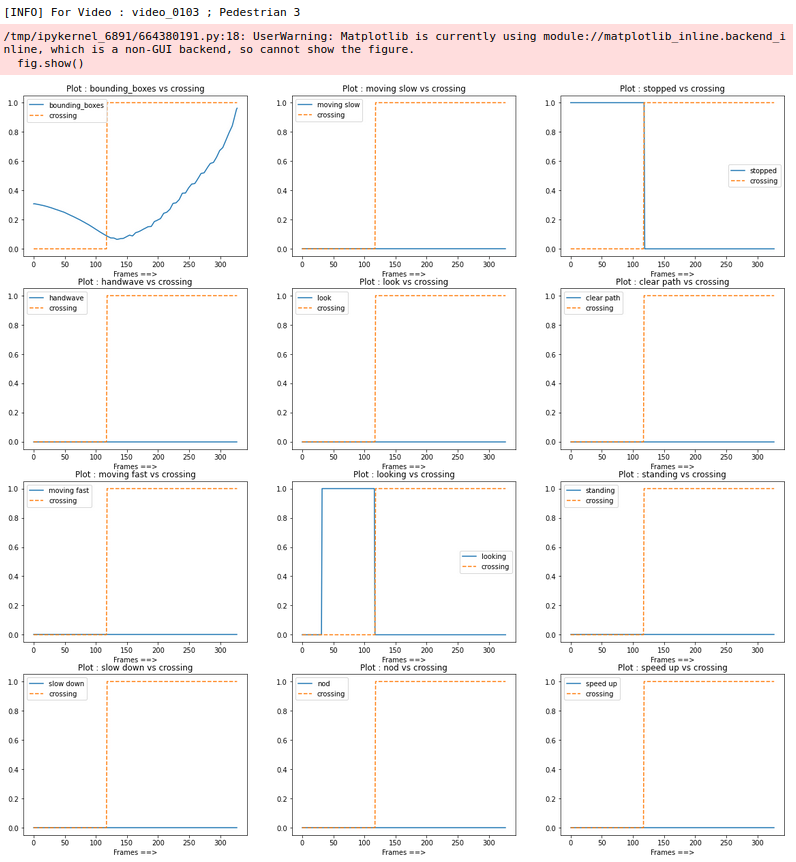

## 2. Redefine the problem and specify metric
The problem to predict the crossing intent of a pedestrain now reduces to extracting the features of given dataset and deducing the patterns between the past values of these features during a window of previous frames and predicting the probability of a pedestrian crossing in the current frame.

As a binary classification problem, the appropriate metric to judge the performance of model will be using the F1 score. It is a strong metric which takes account of both precision and recall values to analyze the performance of the model. Compared to raw accuracy metric, F1 score provides more robust evaluations on imbalanced datasets in which it is very easy to score high accuracy by classifying every data point to same class.

Given the True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN) between grount truth and predictions, Following is the mathematical formulation of F1 Score:

### $ F1 score = \frac{2}{ \frac{1}{precision} + \frac{1}{recall}} $

where $ precision = \frac{TP}{TP+FP} $
and $ recall = \frac{TP}{TP+FN} $

## 3. Unravel the dataset to per pedestrian per frame format
As stated above the problem can be solved if for each frame a model is able to find patterns in the features aggregrated through past frames. For each frame model takes in as inputs the features of past window of frames, for this entire dataset needs to be re-arranged from per-pedestrian order to per-predestrian-per-frame order. To do this the dataset is unraveled. 

It is worth noting, this approach requires specifying a window size n, hence for each pedestrians no predictions or datapoints will be extracted for first n frames. Thus, these frames are skipped while unraveling the dataset.

To illustrate better, in data_per_frame the dataset has been unraveled to formulate frame wise data for each pedestrian in each video.

The data for frame k of pedestrian 'j' in 'video_i' is given by the row

$ [video\_i, j, k, Y, feat1_{j-n}, feat2_{j-n},....,feat12_{j-n}, feat1_{j-(n-1)}, feat2_{j-(n-1)},...., feat12_{j-(n-1)},......, feat1_{j-1}, feat2_{j-1},....feat12_{j-1}] $

Here, $Y$ = output ('crossing')

And  $X = [feat1, feat2,....., feat12]$ ==> \['moving slow', 'stopped', 'handwave', 'look', 'clear path',
                     'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up', 'bounding_boxes (x_coordinate)'\]
                     
The benefit of unraveling the dataset is that now that for each frame of each pedestrian in a given video we now have a vectorized encoding of its features in past frames of window size n.

Another benefit is that now the encoding can be shuffled before training and will help the model generalize over the dataset better

In [ ]:
 def parse_bbox_x(elements):
    '''
    Function to parse and normalize the bounding box 
    x-coordinate value for each pedestrian data point
    Input: Pedestrian bounding box data for all frames in the video
    Ouput: Normalized bounding box x-coordinate data
    '''
    output = []
    for i in range(len(elements)):
        output.append(
            round(int(float(elements[i][0]) + float(elements[i][2])*0.5)/img_w, 5))
    return output

def parse_bbox_y(elements):
    '''
    Function to parse and normalize the bounding box 
    y-coordinate value for each pedestrian data point
    Input: Pedestrian bounding box data for all frames in the video
    Ouput: Normalized bounding box y-coordinate data
    '''
    output = []
    for i in range(len(elements)):
        output.append(
            round(int(float(elements[i][1]))/img_h, 5))
    return output


def arrange_data_per_frame(data, window_size, feature_set=feature_set_full):
    data_per_frame = []
    # loop through each data row, every row contains 
    # frame-by-frame data of a pedestrian which is to be unraveled
    for i, row in data.iterrows():
        # segregrate features of the dataset that model needs to be trained on
        attr_list = feature_set
       
        
        # get the frames and outputs of crossing for all the frames
        frames = row['frame_numbers']
        outputs = row['crossing']
        
        # empty container to hold data for each feature and populate it with data feature-wise
        # data for bounding box feature should be handled separately
        attributes = {}
        for attr in attr_list[:-1]:
            attributes[attr] = row[attr]
        attributes['bounding_boxes'] = parse_bbox_x(row['bounding_boxes'])
        
        # loop through every frame
        for j in range(len(frames)):
            if(j>=window_size):
                # if sufficient frames have been initialized, curate data of previous frames
                # data for each frame is arranged above explained format
                data_pt = []
                data_pt.append(row['video_id'])
                data_pt.append(row['ped_ind'])
                data_pt.append(frames[j])
                data_pt.append(outputs[j])
                
                # gather data for previous frame for each feature, bounding boxes to be handled separately
                for k in range(window_size, 0, -1):
                  for attr in attr_list:
                    if attr=='bounding_boxes':
                        data_pt.append(attributes[attr][j-k])
                    else:
                        data_pt.append(int(attributes[attr][j-k]))
                data_pt[3] = int(data_pt[3])
                # populate the output list for with data of each frame
                data_per_frame.append(data_pt)
    return data_per_frame

# unravel the data for each pedestrian on per frame basis
window_size = 10

data_per_frame = arrange_data_per_frame(data, window_size)
print("[INFO] Total number of data points: ", len(data_per_frame))

## 4. Baseline model
A naive way to solve this problem will be if model predicts average from previous frames' crossing value as the prediction for the current frame.

For this approach first the data is extracted in per frame format again with window size of 0. Next a moving average of crossing value of previous n frames is predicted as the output for current frame

In [12]:
# unravel data for each frame in the dataset
data_extract_window_size = 0
data_per_frame = arrange_data_per_frame(data, data_extract_window_size)

# define moving average window and initialize containers to hold predictions and ground truth
Y_gt=[]
Y_pred = []
moving_avg_window_size = 15
prev_frames = []

# loop through each frame
for i in range(1, len(data_per_frame)):
    # check if the pedestrian data is same as previous 
    if (data_per_frame[i][0] == data_per_frame[i-1][0]) and (data_per_frame[i][1] == data_per_frame[i-1][1]):
        # check if sufficient number of frames have been initialized for moving average 
        if len(prev_frames)>=moving_avg_window_size:
            # aggregrate ground truth
            Y_gt.append(data_per_frame[i][3])
            
            # aggregrate the average prediction of previous frames and aggregrate it in output predictions
            last_frames_pred = int(sum(prev_frames)/len(prev_frames)>=0.5)
            Y_pred.append(last_frames_pred)
            
            # move the sliding window
            prev_frames = prev_frames[1:]
            prev_frames.append(last_frames_pred)
        else:
            # re-initialize the previous frame container to store data of new pedestrian
            prev_frames.append(data_per_frame[i][3])
    else:
        prev_frames = []     
print("[INFO] Accuracy for moving average of size {} : {:.3f}% ".format(moving_avg_window_size, 100*f1_score(Y_gt, Y_pred)))

[INFO] Accuracy for moving average of size 15 : 60.451% 


### Observation
This naive approach although provides F1 score of 60% on evaluation. It's clear that since the prediction for each frame is completely biased by the prediction for previous frame's prediction, the model is not able to judge the intances when the intention of the pedestrian changes from False to True or vice versa.

Furthermore the subtle visual cues such as looking and stopped state of the pedestrian are completely ignored. A learning based approach on the other hand is capable of taking into the account other features

## Moving towards Machine Learning approaches
Machine Learning approaches are capable of extracting patterns from the input data and make more generalized predictions instead of relying on biased cues.

For this problem, two ML based approaches were tested. First is sklearn's Random Forest Classifier. Second approach is deep neural network based.

Data is still extracted for a window of previous frame. Hence for a window size n, model recieves an input which aggregrates the features from previous n frames. The feature size of each data point is NX12. Where 12 is the number of difference features in the dataset.

First step is to extract this data for a window size 15. This data is then shuffled to introduce the randomness in dataset which will help model in computing better generalization.

In [13]:
# unravel the data for training for window size of 15 and shuffle it to introduce randomness
window_size = 15
data_per_frame = arrange_data_per_frame(data, window_size)
random.shuffle(data_per_frame)

## 5. Split this data into training and validation set
To perform training and evaluation of the model it is important to divide the dataset into training and test datasets. During the training phase, model is only provided the training data as input. During the testing phase, model processes the test data which provides the evaluation of model's capability to generalize on unseen dataset.

Dataset was split with a ratio of 70%-30% using the sklearn library. Finally then data is split into X and Y format to facilitate supervised training

In [14]:
# split the dataset into training-test and input-output
train_data, test_data = train_test_split(data_per_frame, test_size=0.30, random_state=42)

X_train=[]
Y_train=[]
for data_pt in train_data:
  X_train.append(data_pt[4:])
  Y_train.append(data_pt[3])

X_test= []
Y_test = []
for data_pt in test_data:
  X_test.append(data_pt[4:])
  Y_test.append(data_pt[3])

## 6. Training the models
With dataset ready, model is finally ready to be trained.

### 1. Random Forest Classifier training

In [15]:
# initialize the random forest classifier and train for the data
original_random_forest_model = RandomForestClassifier()
original_random_forest_model.fit(X_train, Y_train)

RandomForestClassifier()

### 2. Deep Neural network training
Deep neural networks are much stronger at predicting patterns in high dimensional non linear input data.

For this problem, a simple fully connected neural network with 3 hidden layers was chosen. Standard deep learning practices like dropouts, regularization and learning rate decay were kept in mind to extract the most out of the network. Network learns with the help of Binary Cross Entropy loss function applied to a sigmoid output.

First step is to create the model architecture and the data loaders in PyTorch

In [16]:
class IntentClassifier(nn.Module):
    '''
    Architecture of the Deep Neural Network
    '''
    def __init__(self, time_window, hidden_sizes):
        super().__init__()
        # input size of network depends on total number of different features
        self.num_features = 12
        self.input_size = time_window * self.num_features
        self.input_nodes = 64
        # define the sequential layers
        self.layers = nn.Sequential(nn.Linear(self.input_size, self.input_nodes),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(self.input_nodes, hidden_sizes[0]),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5),
                                   nn.Linear(hidden_sizes[2], 1),
                                   nn.Sigmoid())
    # DNN forward pass
    def forward(self, x):
        x = self.layers(x);
        return x

class PedestrianDataset(Dataset):
    '''
    Class to handle the dataset generation in trainable format from the unraveled dataset
    '''
    def __init__(self, data_points):
        super().__init__()
        self.data_points = data_points
    def __len__(self):
        return len(self.data_points)
    def __getitem__(self, idx):
        
        # class method to return data point input and output in dictionary format after converting to torch tensor
        data_frame = self.data_points[idx]
        sample = {
            "video_id": data_frame[0],
            "ped_id": data_frame[1],
            "frame_num": data_frame[2],
            "features": torch.from_numpy(np.array(data_frame[4:], dtype=np.float32)),
            "output": torch.from_numpy(np.array(data_frame[3], dtype=np.float32))}
        return sample

# specify the device for training and testing if GPU available and initialize the DNN on this device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_dnn_model = IntentClassifier(window_size, [256, 512, 256]).to(device)

# construct the dataloaders wrapped around the dataset class for training and testing
trainloader = DataLoader(PedestrianDataset(train_data),
                        batch_size=64,
                        shuffle=True)
valloader = DataLoader(PedestrianDataset(test_data),
                      batch_size=64,
                      shuffle=False)

# specify training configurations

# weight decay introduces regularization
weight_decay = 1e-5

# specify number of epochs and validation intervals
epochs = 20
val_every=5

# specify the SGD optimizer and loss function to teach the network
optimizer = torch.optim.SGD(original_dnn_model.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, np.arange(5, epochs, 5), gamma=0.1)
loss_criteria = nn.BCELoss()

Next step is to define the training and validation pipelines for the PyTorch API

In [17]:
def train(model, loss_crit, opt, dataloader):
    '''
    Method to define the training pipeline
    
    This pipeline uses data loaders to generate random data through entire training dataset once
    '''
    # initialize training mode
    model.train()
    pbar = tqdm(dataloader, position=0, leave=True)
    total_loss=0
    count=0
    # loop through entire dataset
    for sample in pbar:
        # initialize loss 
        loss = 0.0
        count+=1
        
        # extract input and output from the batch loaded by the data loader
        feats = Variable(sample["features"].to(device))
        target = Variable(sample["output"].to(device))
        
        # forward pass and loss calculation
        pred = model(feats).squeeze(dim=1)
        loss = loss_crit(pred, target)
        
        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # book-keeping of loss values
        total_loss+=loss.item()
        pbar.set_description(
        "Loss {:.3f} | Avg Loss {:.3f}".format(loss.item(), total_loss/(4*(count)))
        )

def validate(model, loss_crit, dataloader):
    '''
    Method to define the validation pipeline to predict class probaility on untrained data
    
    This pipeline uses data loaders to generate random data through entire testing dataset once
    '''
    # set model in validation mode
    model.eval()
    # reduce any accumulated gradients to zero
    with torch.no_grad():
        total_loss =0
        count=0
        pbar = tqdm(dataloader, position=0, leave=True)
        # loop through entire dataset
        for sample in pbar:
            # extract input and output from the batch loaded by the data loader
            feats = Variable(sample["features"].to(device))
            target = Variable(sample["output"].to(device))
            
            # forward pass and loss calculation
            pred = model(feats).squeeze(dim=1)
            loss = loss_crit(pred, target)
            
            # book-keeping of loss values
            total_loss+=loss.item()
            count+=1
            pbar.set_description(
            "Loss {:.3f} | Avg Loss {:.3f}".format(loss.item(), total_loss/((count)))
            )

Finally the neural network is ready to be trained.

Model was trained for 100 epochs and validated on every 5th epoch

In [19]:
# create a training loop that calls train function once for each epoch
for i in range(epochs):
    print("Epoch {:d}".format(i))
    
    train(original_dnn_model, loss_criteria, optimizer, trainloader)
    sched.step(i)
    
    # evaluate and save checkpoints at only specified intervals
    if i%val_every==0:
        print("EVALUATING")
        with torch.no_grad():
            validate(original_dnn_model, loss_criteria, valloader)
        torch.save(original_dnn_model.state_dict(), "output/checkpoint_PA.pth")

Epoch 0


Loss 0.041 | Avg Loss 0.053: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:04<00:00, 318.38it/s]


EVALUATING


Loss 0.210 | Avg Loss 0.129: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 656.76it/s]


Epoch 1


Loss 0.400 | Avg Loss 0.033: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 333.24it/s]


Epoch 2


Loss 0.272 | Avg Loss 0.030: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:05<00:00, 256.61it/s]


Epoch 3


Loss 0.049 | Avg Loss 0.028: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 355.09it/s]


Epoch 4


Loss 0.029 | Avg Loss 0.027: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 336.38it/s]


Epoch 5


Loss 0.034 | Avg Loss 0.026: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 355.95it/s]


EVALUATING


Loss 0.236 | Avg Loss 0.098: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 730.31it/s]


Epoch 6


Loss 0.024 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 357.51it/s]


Epoch 7


Loss 0.251 | Avg Loss 0.026: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 354.88it/s]


Epoch 8


Loss 0.472 | Avg Loss 0.026: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 355.31it/s]


Epoch 9


Loss 0.174 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 353.59it/s]


Epoch 10


Loss 0.032 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 362.56it/s]


EVALUATING


Loss 0.234 | Avg Loss 0.097: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 738.22it/s]


Epoch 11


Loss 0.272 | Avg Loss 0.026: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 360.52it/s]


Epoch 12


Loss 0.024 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 350.66it/s]


Epoch 13


Loss 0.017 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 355.02it/s]


Epoch 14


Loss 0.221 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 357.30it/s]


Epoch 15


Loss 0.026 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 354.78it/s]


EVALUATING


Loss 0.234 | Avg Loss 0.097: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 723.81it/s]


Epoch 16


Loss 0.040 | Avg Loss 0.026: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 351.48it/s]


Epoch 17


Loss 0.016 | Avg Loss 0.026: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 359.79it/s]


Epoch 18


Loss 0.021 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 355.67it/s]


Epoch 19


Loss 0.031 | Avg Loss 0.025: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:03<00:00, 351.26it/s]


## 7. Validation of models on test dataset

Both the models need to be tested with the unseen data to get a comprehensive evaluation of their capability to genralize. Validation was performed according to the F1 score metric, which is widely accepted as the best metric for evaluation in binary classification problems.

First the random classifier model is validated on test dataset.

In [20]:
# get predictions from random classifier on unseen test data and calculate F1 score metric
Y_test_pred = original_random_forest_model.predict(X_test)
print("[INFO] For random forest classifier, F1 Score : {:.3f}%".format(f1_score(Y_test, Y_test_pred)*100))

[INFO] For random forest classifier, F1 Score : 98.523%


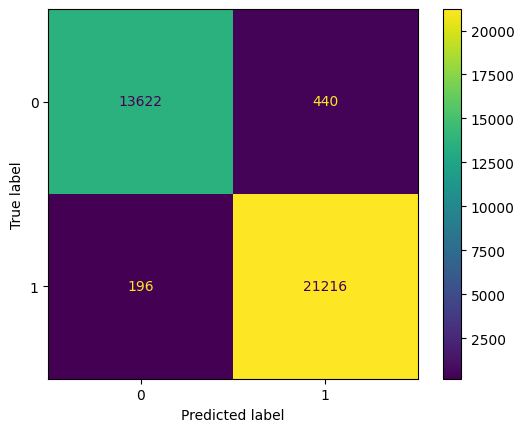

In [21]:
# plot the confusion matrix for the random forest model on validation dataset
cm_random_forest = confusion_matrix(Y_test, Y_test_pred, labels = original_random_forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest, display_labels=original_random_forest_model.classes_)
disp.plot()
plt.show()

Testing the deep neural network classifier on test dataset

In [22]:
def test(model, dataloader):
    '''
    Method to define the testing pipeline for binary prediction
    
    As opposed to validation this pipeline predicts a binary class instead of probability values.
    This is important to calculate the F1 score on test dataset

    This pipeline uses data loaders to generate random data through entire testing dataset once
    '''
    # set model in validation mode
    model.eval()
    
    # initialize containers to hold ground truth and predictions
    ground_truth = []
    predicted = []
    
    # reduce any accumulated gradients to zero
    with torch.no_grad():
        pbar = tqdm(dataloader)
        count=0
        # loop through entire dataset
        for sample in pbar:
            # extract input and output from the batch loaded by the data loader
            feats = Variable(sample["features"].to(device))
            target = Variable(sample["output"].to(device))
            
            # forward pass
            pred = model(feats).squeeze(dim=1)
            
            # ground truth and prediction book-keeping
            # predictions are saved in binary format
            ground_truth.append(target.item())
            predicted.append(float(pred.item()>=0.5))
            count+=1
            pbar.set_description("Processing ... {}/{}".format(count, len(dataloader)))
    return ground_truth, predicted

# initialize containers to hold ground truth and predictions
Y_test_gt = []
Y_test_pred = []

# initialize test dataloader with batch size 1
testloader = DataLoader(PedestrianDataset(test_data),
                      batch_size=1,
                      shuffle=False)

# test the trained model with above pipeline and evaluate the F1 score
Y_test_gt, Y_test_pred = test(original_dnn_model, testloader)
print("[INFO] For deep neural network, F1 score : {:.3f}%".format(100*f1_score(Y_test_gt, Y_test_pred)))

Processing ... 2976/35474:   8%|███████▏                                                                                 | 2881/35474 [00:02<00:25, 1264.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing ... 7772/35474:  22%|███████████████████▎                                                                     | 7701/35474 [00:05<00:23, 1195.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing ... 12497/35474:  3

[INFO] For deep neural network, F1 score : 98.236%


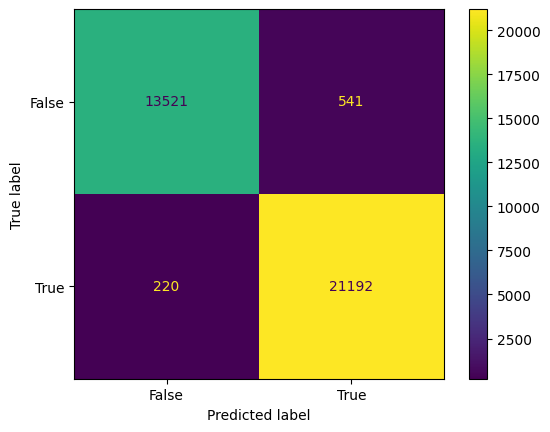

In [31]:
# plot the confusion matrix for the neural network model on validation dataset
cm_dnn_model = confusion_matrix(Y_test_gt, Y_test_pred, labels = [False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dnn_model, display_labels=[False, True])
disp.plot()
plt.show()

## 8. Visualization
It is absolutely necessary to visualize the performance of model over a sequence of video. For this 'video_0071' from JAAD dataset was selected. This video particularly has one crossing pedestrian and one non crossing pedestrian and visualization is very intuitive. Results can be visualized for both pedestrians

NOTE: Visualizations have been performed with the deep neural network

In [25]:
def get_data_for_video(data, video_name, ped_id):
    '''
    Method to extract data for desired video and pedestrian
    '''
    data_for_video = []
    # unravel the dataset again, this time without shuffling
    data_per_frame = arrange_data_per_frame(data, window_size)
    # loop through the unraveled dataset
    for data_pt in data_per_frame:
        if(data_pt[0] == video_name and data_pt[1]==ped_id):
            data_for_video.append(data_pt)
    return data_for_video

# extract data for pedestrian 1
data_video_ped_1 = get_data_for_video(data, 'video_0071', '1')

# create dataloader of batch size 1 for testing with dnn
testloader_1 = DataLoader(PedestrianDataset(data_video_ped_1),
                      batch_size=1,
                      shuffle=False)
print(len(data_video_ped_1))

# extract data for pedestrian 2
data_video_ped_2 = get_data_for_video(data, 'video_0071','2')
# create dataloader of batch size 1 for testing with dnn
testloader_2 = DataLoader(PedestrianDataset(data_video_ped_2),
                      batch_size=1,
                      shuffle=False)
print(len(data_video_ped_2))

315
283


In [26]:
def inference(model, dataloader):
    '''
    Method to run inference on the pedestrian data frame-by-frame and return predictions for each frame
    '''
    # set model in evaluation mode
    model.eval()
    
    # initialize empty containers to hold ground truth and prediction
    ground_truth = []
    predicted = []
    
    # reduce any accumulated gradients to zero
    with torch.no_grad():
        pbar = tqdm(dataloader)
        count=0
        
        # loop through entire dataset
        for sample in pbar:
            
            # extract input and out from each data point extracted by dataloader
            feats = Variable(sample["features"].to(device))
            target = Variable(sample["output"].to(device))
            
            # forward pass
            pred = model(feats).squeeze(dim=1)
            
            # book-keeping of ground truth and predictions
            ground_truth.append(target.item())
            predicted.append(pred.item())
            count+=1
            pbar.set_description("Processing ... {}/{}".format(count, len(dataloader)))
    return ground_truth, predicted

In [27]:
# run inference for pedestrian 1 of video_0071
gt_ped_1,preds_ped_1 = inference(original_dnn_model, testloader_1)

# run inference for pedestrian 2 of video_0071
gt_ped_2, preds_ped_2 = inference(original_dnn_model, testloader_2)

Processing ... 283/283: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 1280.38it/s]


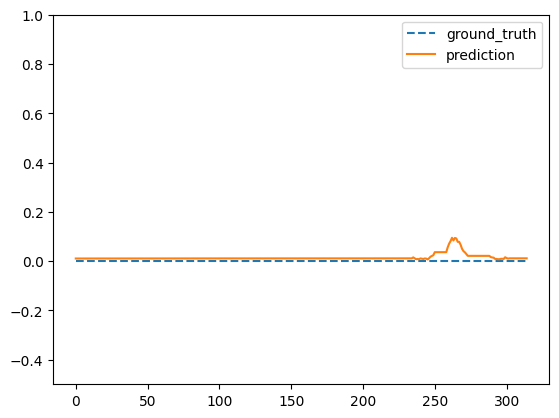

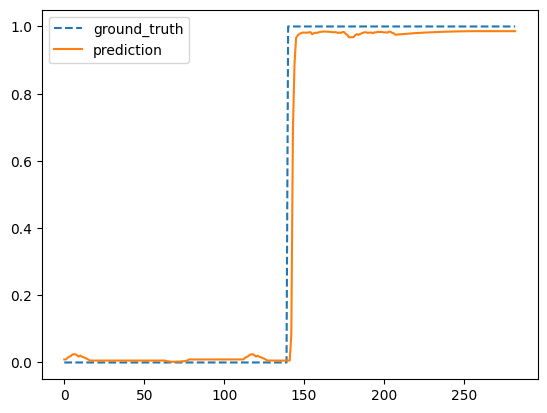

In [28]:
# plot frame-by-frame ground truth and prediction for pedestrian 1
frames = range(0,len(gt_ped_1))
plt.plot(frames, gt_ped_1, linestyle='dashed')
plt.plot(frames, preds_ped_1)
plt.legend(['ground_truth','prediction'])
plt.ylim([-0.5, 1])
plt.show()

# plot frame-by-frame ground truth and prediction for pedestrian 2
frames = range(0,len(gt_ped_2))
plt.plot(frames, gt_ped_2, linestyle='dashed')
plt.plot(frames, preds_ped_2)
plt.legend(['ground_truth','prediction'])
plt.show()

### Visualization on images
In any computer vision application, it is important to visualize the results on image data. Above predicted values for crossing at each frame can visualized on video_0071 using OpenCV

In [29]:
def visualize_on_video(video_predictions, window_size=15):
    ret = True
    count = 0
    # load the video reading and writing object from opencv
    vid = cv2.VideoCapture('video/video_0071.mp4')
    video_writer = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (img_w,img_h))
    while(True):
        # loop through each frame
        ret, image = vid.read()

        if(ret):
            frame = image.copy()
            count+=1
            # ensure that sufficient amount of frame have been initialized
            if(count>=window_size):
                # for each pedestrian draw annotations
                for pedestrian_data in video_predictions:
                    if count<=len(pedestrian_data[0]):
                        # calculate the confidence for the predication in current frame for current pedestrian
                        cross_confidence = pedestrian_data[0][count-window_size]
                        # extract bounding box information from the dataset for current frame for each pedestrian
                        bbox_point1 = (int(pedestrian_data[1][count][0] + 0.5*pedestrian_data[1][count][2])-25, int(pedestrian_data[1][count][1]))
                        bbox_point2 = (int(pedestrian_data[1][count][0] + 0.5*pedestrian_data[1][count][2])+25, int(pedestrian_data[1][count][1])+10)
                        # draw annotations on the image according to the probability of prediction
                        if cross_confidence<0.33:
                            cv2.rectangle(frame, bbox_point1, bbox_point2, (0,255,0) , thickness=-1)
                            cv2.putText(frame, "INTENT TO CROSS: LOW {:.2f} %".format(cross_confidence*100), org = bbox_point1, color=(0,255,0), fontFace=cv2.FONT_HERSHEY_SIMPLEX, thickness = 2, fontScale=0.5)
                        elif cross_confidence>=0.33 and cross_confidence<0.5:
                            cv2.rectangle(frame, bbox_point1, bbox_point2, (0,255,255), thickness=-1)
                            cv2.putText(frame, "INTENT TO CROSS: LOW-MEDIUM {:.2f} %".format(cross_confidence*100), org = bbox_point1, color =(0,255,255), fontFace=cv2.FONT_HERSHEY_SIMPLEX, thickness = 2, fontScale=0.5)
                        elif cross_confidence>=0.5 and cross_confidence<0.66:
                            cv2.rectangle(frame, bbox_point1, bbox_point2, color = (0,165,255), thickness=-1)
                            cv2.putText(frame, "INTENT TO CROSS: MEDIUM-HIGH {:.2f} %".format(cross_confidence*100), org = bbox_point1, color =(0,165,255), fontFace=cv2.FONT_HERSHEY_SIMPLEX, thickness = 2, fontScale=0.5)
                        elif cross_confidence>=0.66:
                            cv2.rectangle(frame, bbox_point1, bbox_point2, color = (0,0,255), thickness=-1)
                            cv2.putText(frame, "INTENT TO CROSS: HIGH {:.2f} %".format(cross_confidence*100), org = bbox_point1, color =(0,0,255), fontFace=cv2.FONT_HERSHEY_SIMPLEX, thickness = 2, fontScale=0.5)
            # write frame to video writer object
            video_writer.write(frame)
        else:
            video_writer.release()
            break
# extract bounding box for all frames for each pedestrian
bboxes_ped_1 = data.iloc[0]['bounding_boxes']
bboxes_ped_2 = data.iloc[1]['bounding_boxes']
# encode predictions and bounding box information together for each pedestrian
video_predictions = [[preds_ped_1, bboxes_ped_1], [preds_ped_2, bboxes_ped_2]]

# draw on video frames
visualize_on_video(video_predictions)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


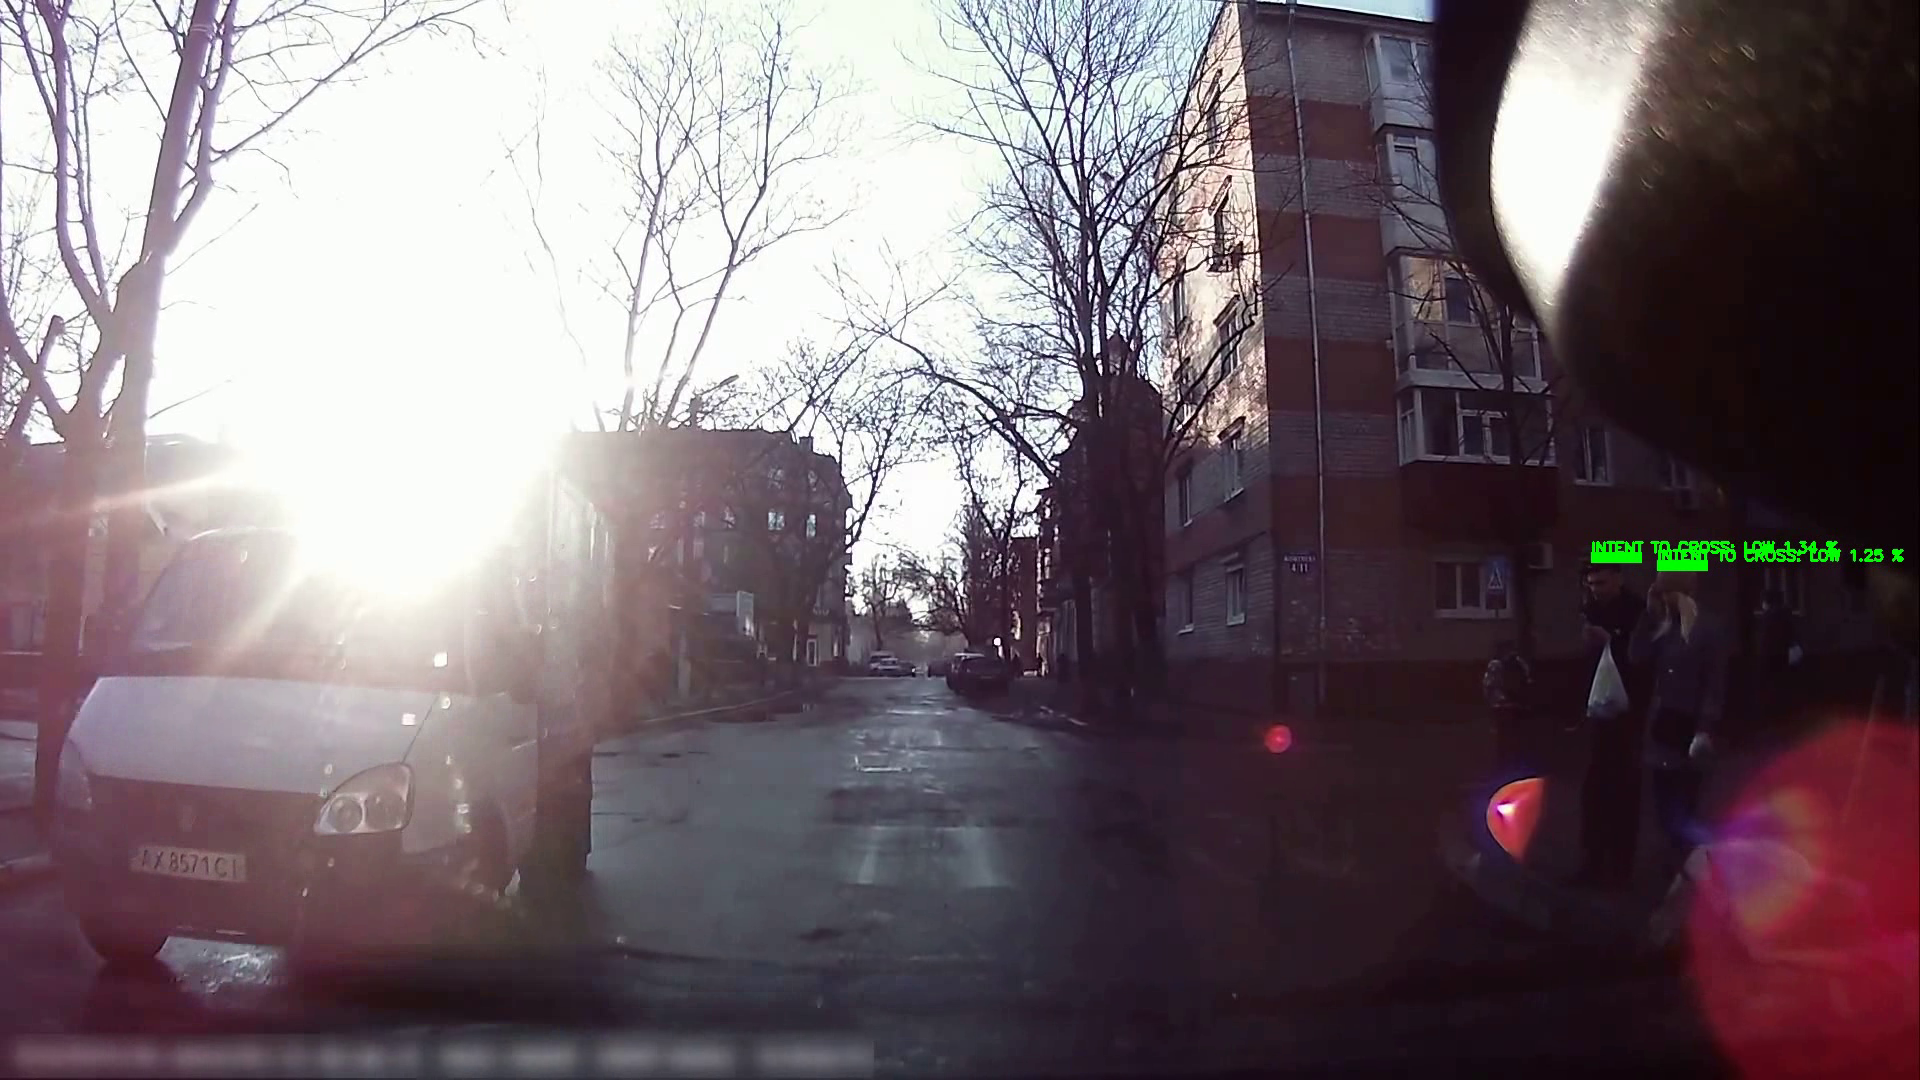

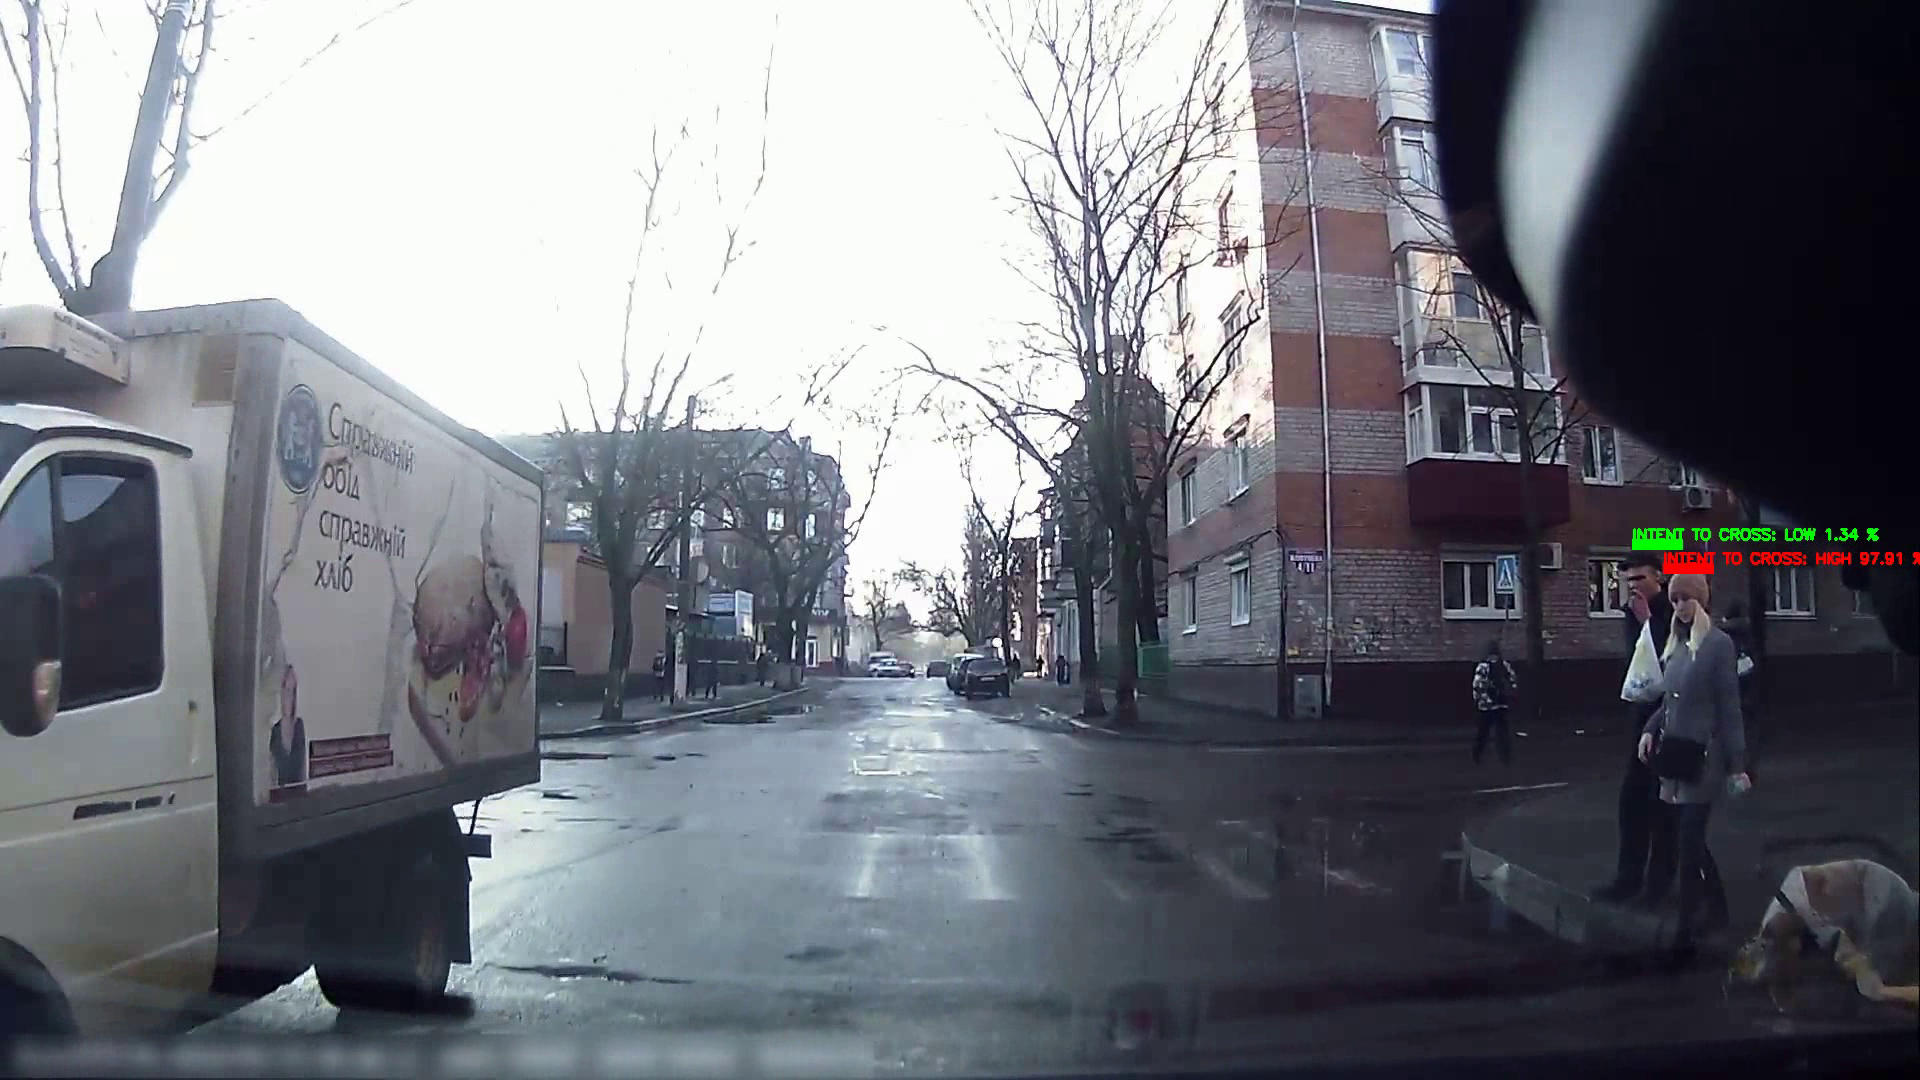

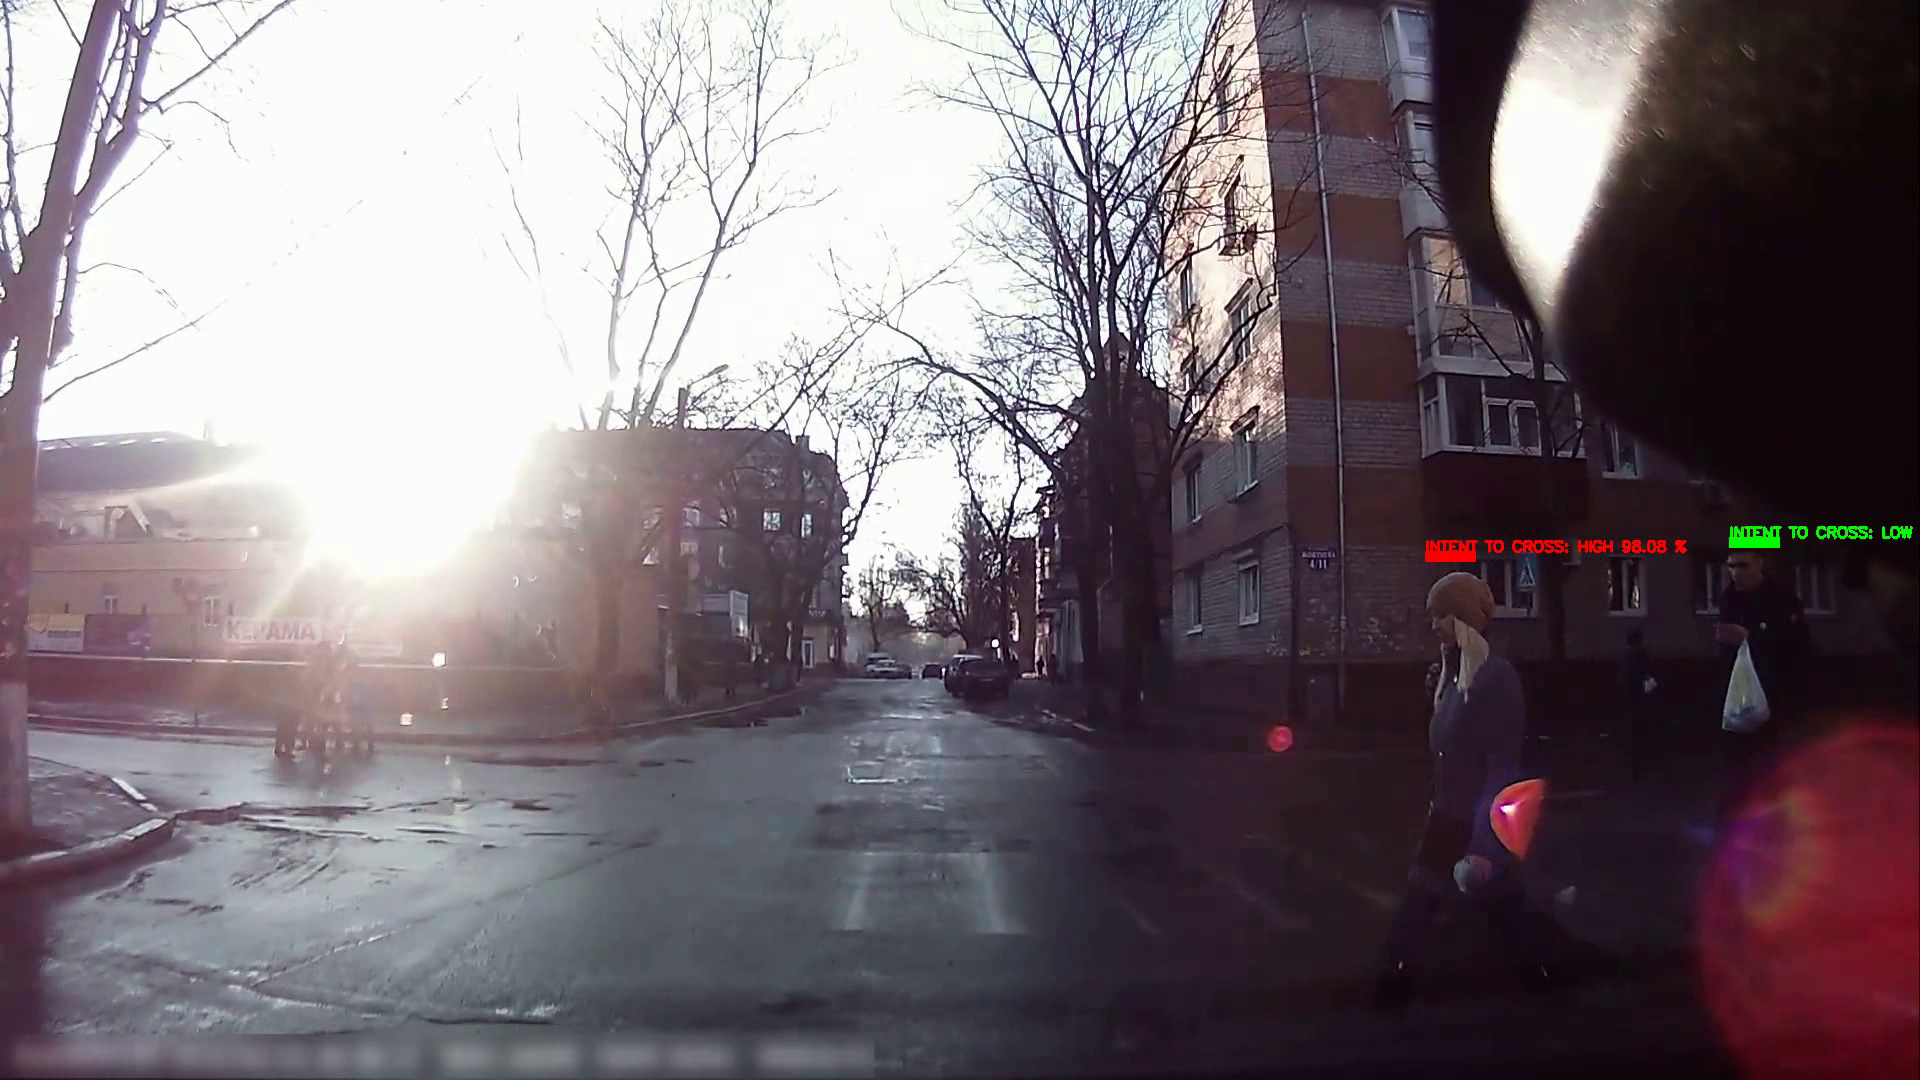

## Analysis

The above code is an implementation of pedestrian intent prediction in autonomous driving scenarios. The dataset provided has carefully annotated to capture subtle human behaviors in streets and sidewalks. The data contains cues for 'looking', 'handwaves', 'moving slow', 'stopped' states of each pedestrian in the video clips of JAAD dataset.

These cues have a high correlation with pedestrian's intent to cross the road. For example a pedestrian is likely to look towards the approaching vehicle before crossing.

Finding underlying patterns in these cues over pedestrian's accumulated history enables the prediction of the future intent of crossing. Machine Learning approaches excel at finding such patterns and produce end-to-end results.

#### Assumptions:
- Intent to cross a road in any given frame is a consequence of visual cues exhibited by pedestrian in previous set of frames
- Crossing in images take place from right-to-left and left-to-right more dominantly that up-down or down-up, hence only x-coordinate of bounding boxes was used as feature for training

#### Findings:
- Both models, random forest classifier and DNN exhibit similar levels of performance on validation datasets
- DNN model requires a more extensive training pipeline, however on larger datasets the performance gains can be expected to be much higher than Random Forest Classifier
- Both model require the knowledge of pedestrian's history in previous frames hence they both depend on tracking methodologies and inevitable have to skip first few frames depending on the window size of previous frames

#### Result for visualization on the video can be found inside the output folder of submission directory